<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Эконометрика</center></h1>
<h2><center>Домашка по временным рядам</center></h2>

Сделали **Пешков Максим, Романенко Александра**

группа **БЭК181**

In [ ]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

In [ ]:
!pip install matplotlib==3.1.3

In [3]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Задание 1 "Взять языка"

В данной работе будут использоваться данные по промышленному производству в США за период с 1940 по 2020 года. За каждый месяц посчитан индекс общей производительности в газовой промышленности и электроэнергетике.

Прямая ссылка, где данные лежат в открытом доступе
https://fred.stlouisfed.org/series/IPG2211A2N

Взять эти данные вдохновили соревнования на Kaggle

https://www.kaggle.com/mmoanis/electric-utilities-production-index-in-the-usa

https://www.kaggle.com/sadeght/industrial-production-electric-and-gas-utilities

А также статья в medium

https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

## Подгрузка данных

In [4]:
!wget -O utilities.csv https://www.dropbox.com/s/xdvsd7s7dffdt11/utilitites.csv?dl=0

--2021-06-16 12:28:53--  https://www.dropbox.com/s/xdvsd7s7dffdt11/utilitites.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xdvsd7s7dffdt11/utilitites.csv [following]
--2021-06-16 12:28:54--  https://www.dropbox.com/s/raw/xdvsd7s7dffdt11/utilitites.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc11775fde4675cdee364b8b4171.dl.dropboxusercontent.com/cd/0/inline/BQiibmDWIvcYv_mDv7F10rtSUupCVrXrn2WpHkgIo3beyrN0qSuVpn_xR37iI9aI80i42KNSVnsIeh52747yd80yGQK7bNWb_p5_yslBuBk_vxS1_cFadLtvLiaKE1p1JAiCfWKC006kBW_Yn7Ziq-K3/file# [following]
--2021-06-16 12:28:54--  https://uc11775fde4675cdee364b8b4171.dl.dropboxusercontent.com/cd/0/inline/BQiibmDWIvcYv_mDv7F10rtSUupCVrXrn2WpHkgIo3beyrN0qSuVpn_xR37iI9aI80i42KNSVnsIeh5

In [5]:
df = pd.read_csv('utilities.csv')

In [6]:
df.head(3)

,DATE,IPG2211A2N
0,1939-01-01,3.3298
1,1939-02-01,3.3552
2,1939-03-01,3.4315


In [7]:
df.tail(3)

,DATE,IPG2211A2N
985,2021-02-01,114.5581
986,2021-03-01,97.7529
987,2021-04-01,86.5131


In [8]:
df.shape

(988, 2)

## Обработка данных

In [9]:
df['Time'] = pd.to_datetime(df["DATE"], infer_datetime_format=True)
df_time = df.Time
df = df.drop('DATE', axis=1)

In [10]:
df = df.rename(columns = {'IPG2211A2N':'uti', 'Time':'Time'})

In [11]:
df.index = pd.PeriodIndex(df.Time, freq='M')
df = df.drop('Time', axis=1)

In [12]:
df.head()

,uti
Time,
1939-01,3.3298
1939-02,3.3552
1939-03,3.4315
1939-04,3.4569
1939-05,3.4569


# Задание 2 "Немалевич"

## График ряда

Используются данные производства в промышленности, для которого очевидно есть зависимость от сезона (зимой электроэнергии и газа больше потребляют и больше производят для этого соответственно). А также так как численность населения растет и сама промышленность растет, то очевидно предполагать положительный тренд.

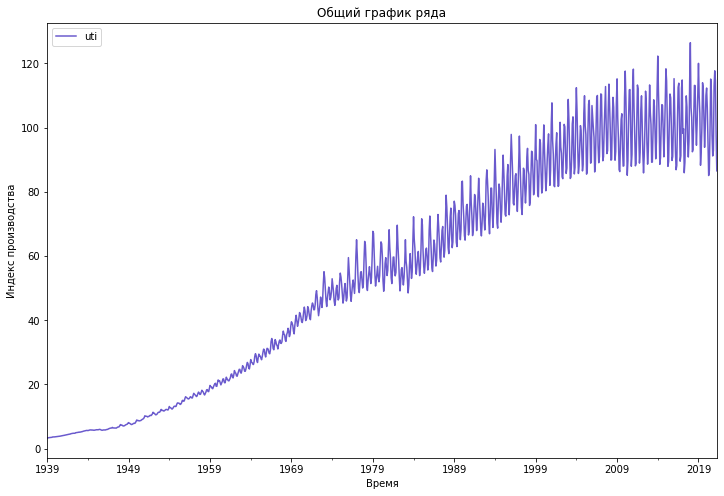

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))
df.plot(ax=ax, color='slateblue')
plt.xlabel('Время')
plt.ylabel('Индекс производства')
plt.title('Общий график ряда')
plt.show();

Из графика видно, что существует положительный тренд и ярко выраженная сезонность

## Графики автокорреляционных функций

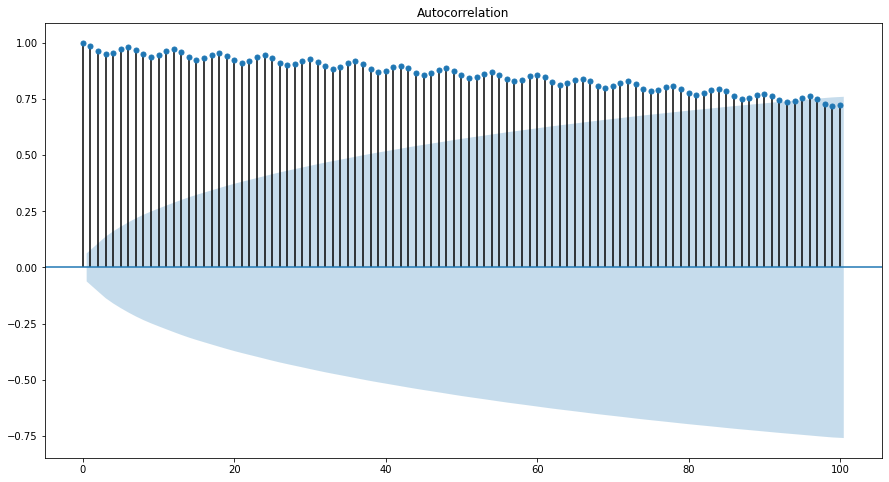

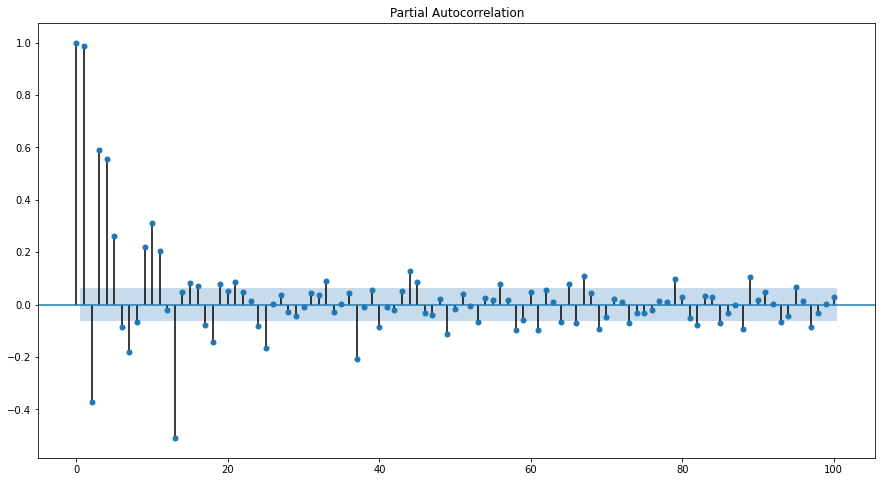

In [14]:
plt.rc("figure", figsize=(15,8))
plot_acf(df.uti, lags=100);
plot_pacf(df.uti, lags=100);


* График автокорреляционной функции показывают, что есть высокая зависимость даже до 100 лага, что подтверждает тренд и сезонность.

* График частной автокорреляционной функции также подтверждает сезонность (высокая корреляция до 17 лага)

## Нарезка по годам для иллюстрации сезонности

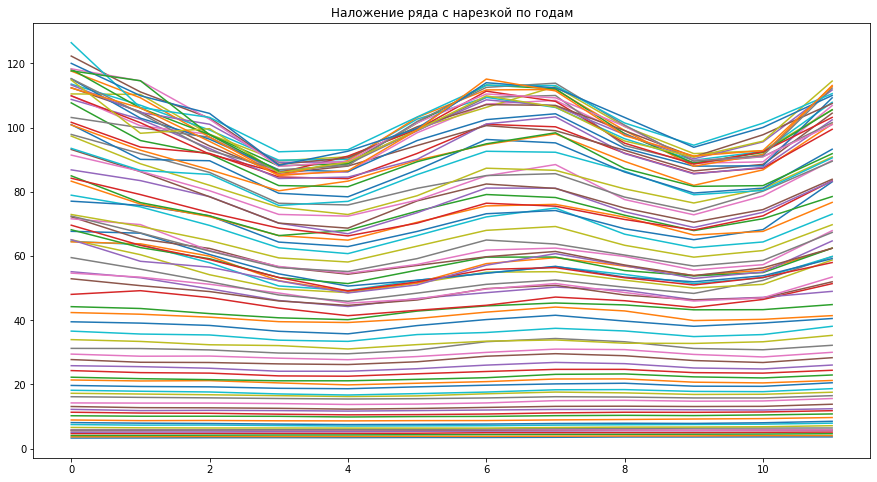

In [15]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
for year in np.arange(1939, 2022):
  arr = df[df.index.year == year].to_numpy()
  plt.plot(arr, label=str(year))
  plt.title('Наложение ряда с нарезкой по годам');

Поскольку у нас довольно большая выборка (более 60 лет) наложение всех годов друг на друга не очень показательно. Сделаем случайную выборку из 10 разных лет и проиллюстрируем помесячное изменение данных

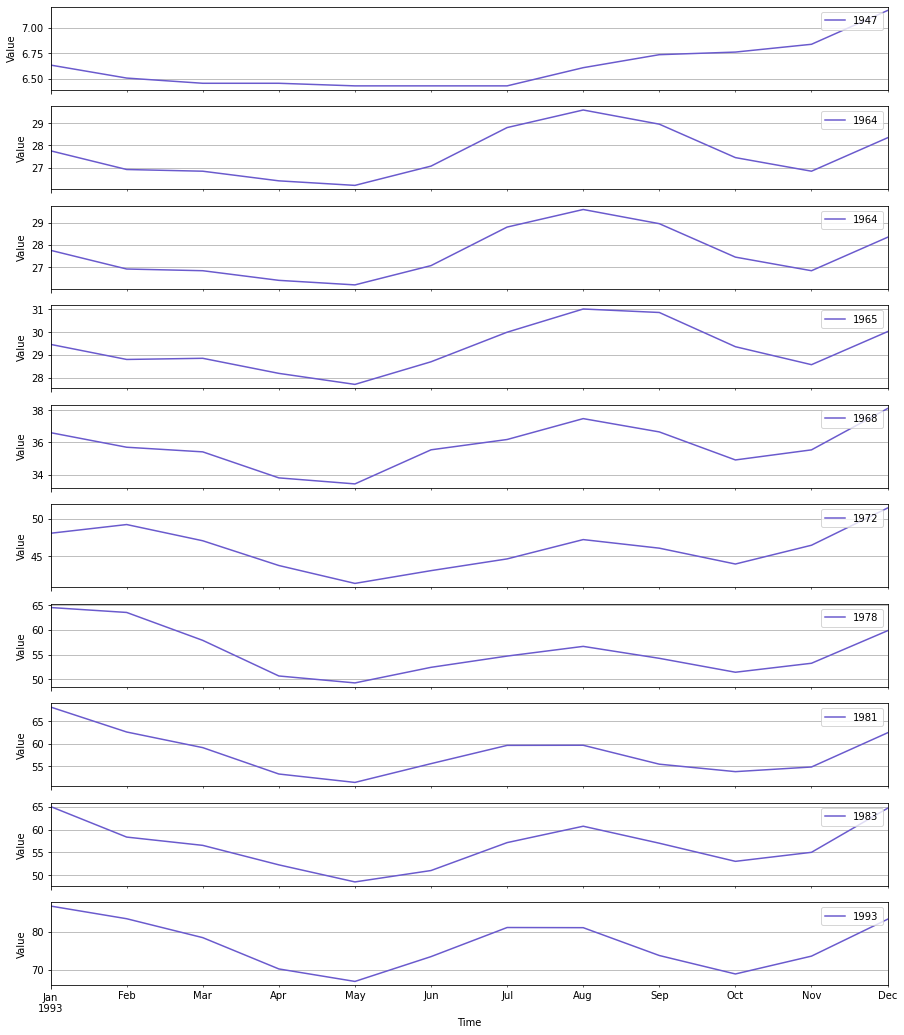

In [16]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(15, 18))
years = df.sample(10).sort_index().index.year
for i in range(0, 10):
  year = years[i]
  df[df.index.year == year].plot(ax=axes[i], label=str(year), 
                                 legend=False, color='slateblue',
                                 sharex=True, grid=True)
  axes[i].legend([str(year)], loc='upper right')
  if i != 9:
    axes[i].set_xlabel("")
  axes[i].set_ylabel('Value');
 

По таким графикам явно видна сезонность (снижение показателя весной и осенью и сильный рост зимой и летом), однако еще лучше сделать декомпозицию

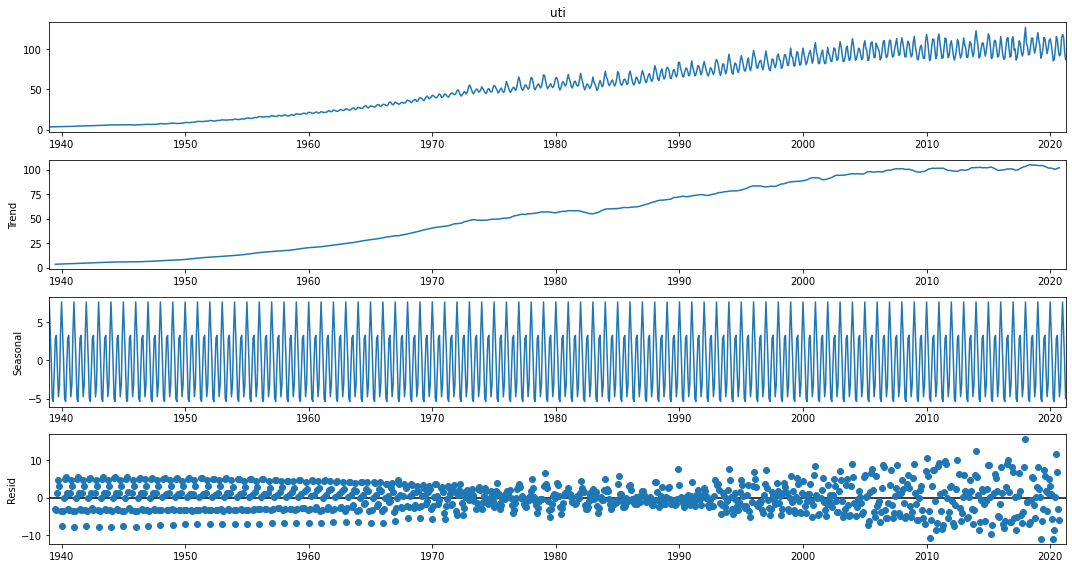

In [17]:
d = df.copy()
d.index = df.index.to_timestamp()
decomposition = seasonal_decompose(d.uti, model = "additive")
decomposition.plot();

# Задание 3 "Твиттер"

* Используемый ряд является сезонным, что показывают как графики автокорреляционных функций (общей и частной), так и вырезки по рандомным годам.

* Для ряда ярко выражен положительный тренд, что видно из общего графика и сильной корреляции в автокорреляционной функции.

* Ряд **не стационарный**, так как есть тренд, сезонность и амплитуда колебаний растет со временем

Проверка на стационарность тестом

In [18]:
test = adfuller(df.uti)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -0.6930481654163088
p-value:  0.8485420114963094
Critical values:  {'1%': -3.4371445907959832, '5%': -2.864539720789528, '10%': -2.5683672133480093}
Есть единичные корни, ряд не стационарен


Попробуем использовать логарифм, так как он позволит стабилизировать амплитуду колебаний ряда.

In [19]:
df['log_uti'] = np.log(df.uti)

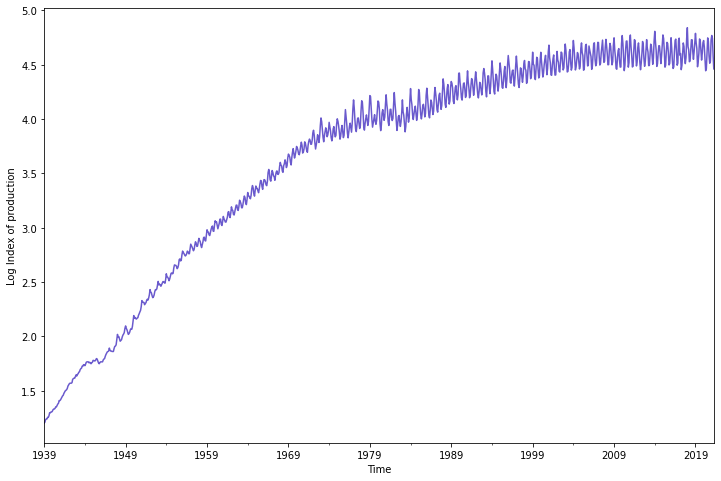

In [20]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))
df.log_uti.plot(ax=ax, color='slateblue')
plt.xlabel('Time')
plt.ylabel('Log Index of production')
plt.show();

Видно, что из-за наличия тренда ряд все еще не очень стационарный (матожидание не константа).

НО давайте попробуем также модели для логарифмированного ряда и может для него будет лучше.

# Задание 4 "Двенадцать месяцев"

In [21]:
from sklearn.metrics import mean_absolute_error as mae

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

from sktime.forecasting.model_selection import temporal_train_test_split

## Подготовка данных

Разобьем на обучающую и тестовую выборки

Причем возьмем тестовую выборку размером в последние 12 лет - примерно 15% от всего временного ряда. Наш используемый ряд достаточно большой, поэтому в целом мы так можем делать.

In [22]:
dflog_train, dflog_test = temporal_train_test_split(df.log_uti, test_size=0.15)

In [23]:
fh = ForecastingHorizon(dflog_test.index, is_relative=False) #зададим для какого времени предсказываем

In [24]:
df_train, df_test = temporal_train_test_split(df.uti, test_size=0.15)

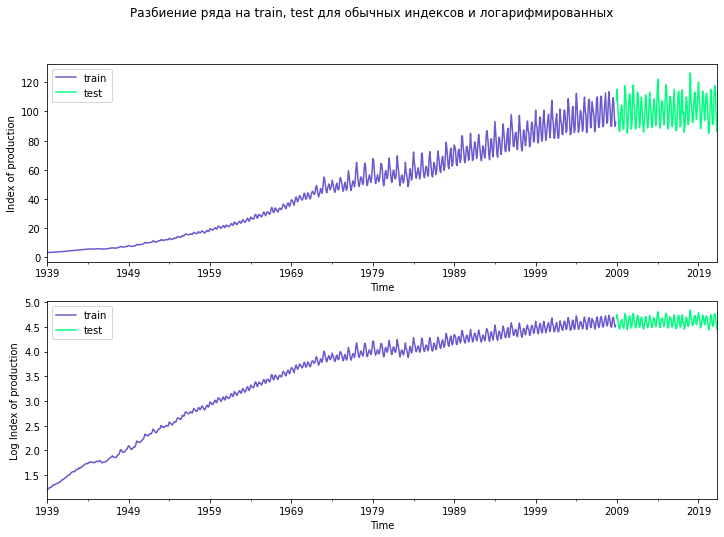

In [25]:
fig, axs = plt.subplots(2,1, figsize=(12, 8))
df_train.plot(ax=axs[0], label='train', color='slateblue')
df_test.plot(ax=axs[0], label='test', color='springgreen')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Index of production')
axs[0].legend()
dflog_train.plot(ax=axs[1], label='train', color='slateblue')
dflog_test.plot(ax=axs[1], label='test', color='springgreen')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Log Index of production')
axs[1].legend()
fig.suptitle('Разбиение ряда на train, test для обычных индексов и логарифмированных')
plt.show();

##  Naive Forecast

### Обычные индексы

In [26]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(df_train)
y_pred_nai = forecaster.predict(fh)

In [27]:
MAE_ind = []
MAE_ind.append(mae(y_pred_nai, df_test))

In [28]:
print(f'MAE для Naive с рядом без логарифма: {mae(y_pred_nai, df_test)}')

MAE для Naive с рядом без логарифма: 10.49972080536913


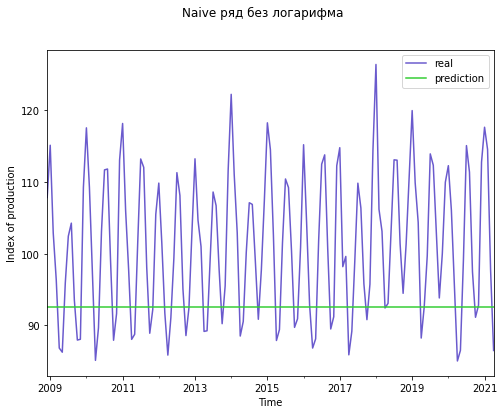

In [29]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
df_test.plot(label='real', color='slateblue')
y_pred_nai.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('Naive ряд без логарифма')
plt.show();

### Логарифмированные

In [30]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(dflog_train)
y_pred_nai_log = forecaster.predict(fh)

In [31]:
MAE_log = []
MAE_log.append(mae(np.exp(y_pred_nai_log), df_test))

In [32]:
print(f'MAE для Naive с лог рядом: {mae(np.exp(y_pred_nai_log), df_test)}')

MAE для Naive с лог рядом: 10.499720805369115


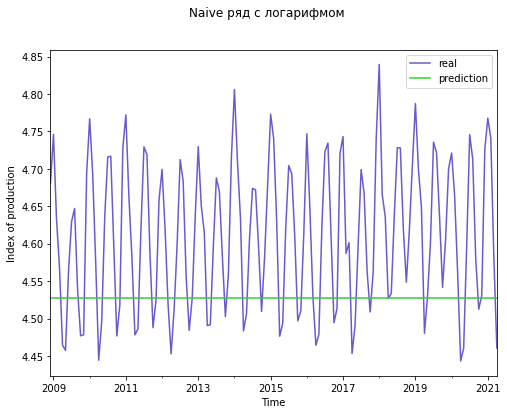

In [33]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
dflog_test.plot(label='real', color='slateblue')
y_pred_nai_log.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('Naive ряд с логарифмом')
plt.show();

## Naive season forecast

### Обычные индексы

In [34]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(df_train)
y_pred_sez = forecaster.predict(fh)

In [35]:
MAE_ind.append(mae(y_pred_sez, df_test))

In [36]:
print(f'MAE Naive season ряд без логарифма: {mae(y_pred_sez, df_test)}')

MAE Naive season ряд без логарифма: 3.1387845637583887


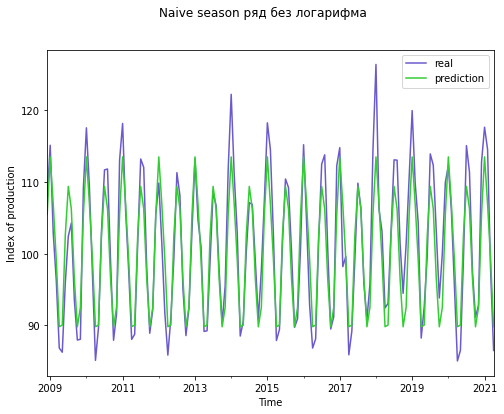

In [37]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
df_test.plot(label='real', color='slateblue')
y_pred_sez.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('Naive season ряд без логарифма')
plt.show();

### Логарифмированные

In [38]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(dflog_train)
y_pred_sez_log = forecaster.predict(fh)

In [39]:
MAE_log.append(mae(np.exp(y_pred_sez_log), df_test))

In [40]:
print(f'MAE Naive season лог ряд: {mae(np.exp(y_pred_sez_log), df_test)}') 

MAE Naive season лог ряд: 3.138784563758392


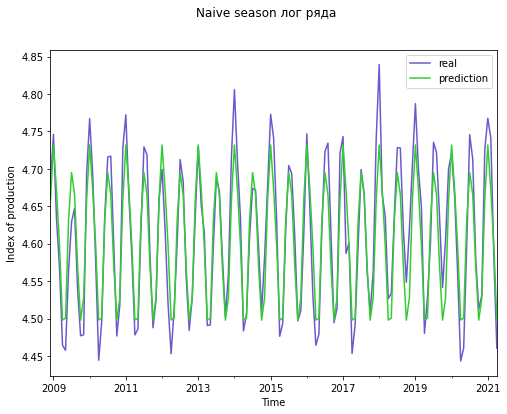

In [41]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
dflog_test.plot(label='real', color='slateblue')
y_pred_sez_log.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('Naive season лог ряда')
plt.show();

## SARIMA(1, 1, 1)(1, 0, 0)[12].

### Обычные индексы

In [42]:
forecaster = ARIMA(
    order=(1, 1, 1), seasonal_order=(1, 0, 0, 12), suppress_warnings=True)
forecaster.fit(df_train)
y_pred_arima = forecaster.predict(fh)

In [43]:
MAE_ind.append(mae(y_pred_arima, df_test))

In [44]:
print(f'MAE SARIMA ряд без логарифма: {mae(y_pred_arima, df_test)}')

MAE SARIMA ряд без логарифма: 8.393493964655033


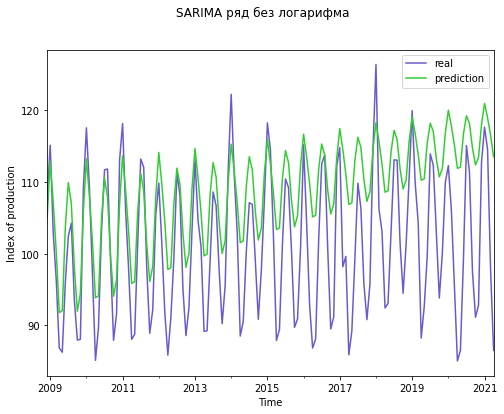

In [45]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
df_test.plot(label='real', color='slateblue')
y_pred_arima.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('SARIMA ряд без логарифма')
plt.show();

### Логарифмированные

In [46]:
forecaster = ARIMA(
    order=(1, 1, 1), seasonal_order=(1, 0, 0, 12), suppress_warnings=True)
forecaster.fit(dflog_train)
y_pred_arima_log = forecaster.predict(fh)

In [47]:
MAE_log.append(mae(np.exp(y_pred_arima_log), df_test))

In [48]:
print(f'MAE SARIMA ряд c логарифмом: {mae(np.exp(y_pred_arima_log), df_test)}')

MAE SARIMA ряд c логарифмом: 16.895219226320528


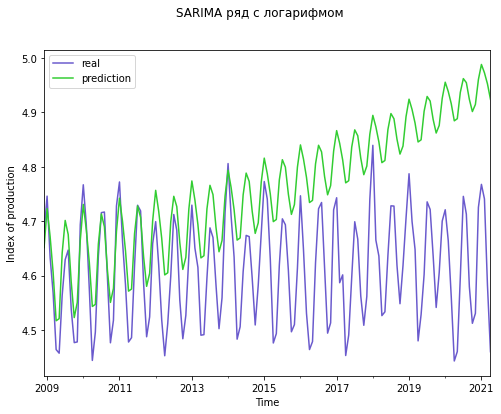

In [49]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
dflog_test.plot(label='real', color='slateblue')
y_pred_arima_log.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('SARIMA ряд с логарифмом')
plt.show();

## Алгоритм Хиндмана-Хандакара автоматического подбора SARIMA

### Обычные индексы

In [50]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(df_train) #долго работает, минут 8-10, не знаю почему, но вот так, нужно потерпеть и не бухтеть))
y_pred_autoarima = forecaster.predict(fh)

In [51]:
MAE_ind.append(mae(y_pred_autoarima, df_test))

In [52]:
print(f'MAE aвтоподбор SARIMA ряд без логарифма: {mae(y_pred_autoarima, df_test)}')

MAE aвтоподбор SARIMA ряд без логарифма: 7.319396362767488


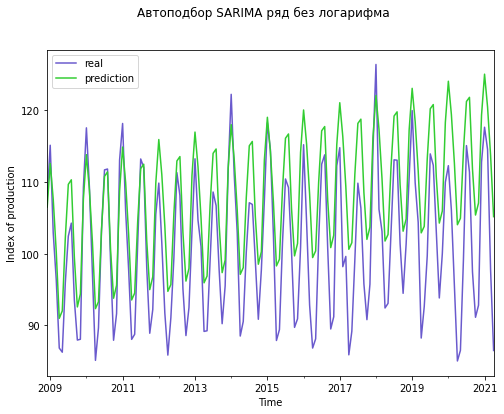

In [53]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
df_test.plot(label='real', color='slateblue')
y_pred_autoarima.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('Автоподбор SARIMA ряд без логарифма')
plt.show();

### Логарифмированные

In [54]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(dflog_train) #долго работает, минут 8-10, не знаю почему, но вот так, нужно потерпеть и не бухтеть))
y_pred_autoarima_log = forecaster.predict(fh)

In [55]:
MAE_log.append(mae(np.exp(y_pred_autoarima_log), df_test))

In [56]:
print(f'MAE aвтоподбор SARIMA ряд c логарифмом: {mae(np.exp(y_pred_autoarima_log), df_test)}')

MAE aвтоподбор SARIMA ряд c логарифмом: 4.784371479881865


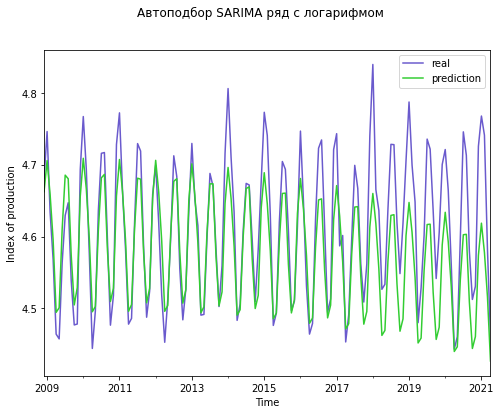

In [57]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
dflog_test.plot(label='real', color='slateblue')
y_pred_autoarima_log.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('Автоподбор SARIMA ряд с логарифмом')
plt.show();

## ETS(AAA)

### Обычные индексы

In [58]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(df_train)
y_pred_ets = forecaster.predict(fh)

In [59]:
MAE_ind.append(mae(y_pred_ets, df_test))

In [60]:
print(f'MAE ETS(AAA) ряд без логарифма: {mae(y_pred_ets, df_test)}') 

MAE ETS(AAA) ряд без логарифма: 8.089911817288026


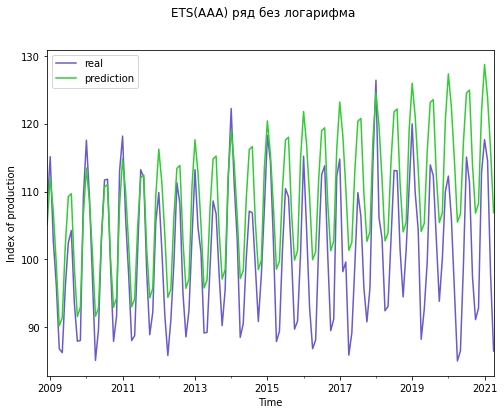

In [61]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
df_test.plot(label='real', color='slateblue')
y_pred_ets.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('ETS(AAA) ряд без логарифма')
plt.show();

### Логарифмированные

In [62]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(dflog_train)
y_pred_ets_log = forecaster.predict(fh)

In [63]:
MAE_log.append(mae(np.exp(y_pred_ets_log), df_test))

In [64]:
print(f'MAE ETS(AAA) ряд с логарифмом: {mae(np.exp(y_pred_ets_log), df_test)}') 

MAE ETS(AAA) ряд с логарифмом: 11.084597693724753


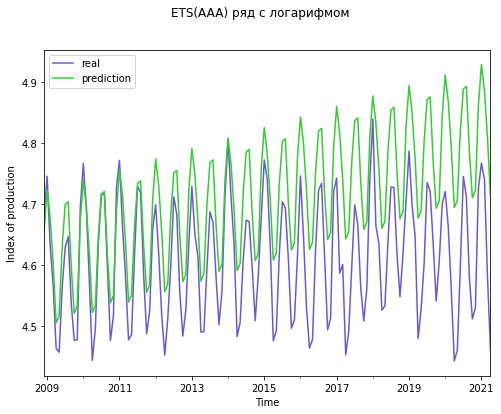

In [65]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
dflog_test.plot(label='real', color='slateblue')
y_pred_ets_log.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('ETS(AAA) ряд с логарифмом')
plt.show();

## AutoETS

### Обычные индексы

In [66]:
forecaster = AutoETS(auto=True, sp=12)
forecaster.fit(df_train)
y_pred_autoets = forecaster.predict(fh)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/exponential_smoothing/ets.py:1135: RuntimeWarning: invalid value encountered in log
  logL -= np.sum(np.log(yhat))
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [67]:
MAE_ind.append(mae(y_pred_autoets, df_test))

In [68]:
print(f'MAE AutoETS ряд без логарифма: {mae(y_pred_autoets, df_test)}') 

MAE AutoETS ряд без логарифма: 8.343410465173655


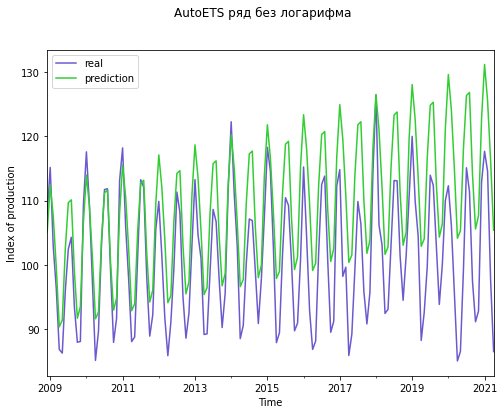

In [69]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
df_test.plot(label='real', color='slateblue')
y_pred_autoets.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('AutoETS ряд без логарифма')
plt.show();

## Логарифмированные

In [70]:
forecaster = AutoETS(auto=True, sp=12)
forecaster.fit(dflog_train)
y_pred_autoets_log = forecaster.predict(fh)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/exponential_smoothing/ets.py:1135: RuntimeWarning: invalid value encountered in log
  logL -= np.sum(np.log(yhat))
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [71]:
MAE_log.append(mae(np.exp(y_pred_autoets_log), df_test))

In [72]:
print(f'MAE AutoETS ряд с логарифмом: {mae(np.exp(y_pred_autoets_log), df_test)}') 

MAE AutoETS ряд с логарифмом: 15.661311391365365


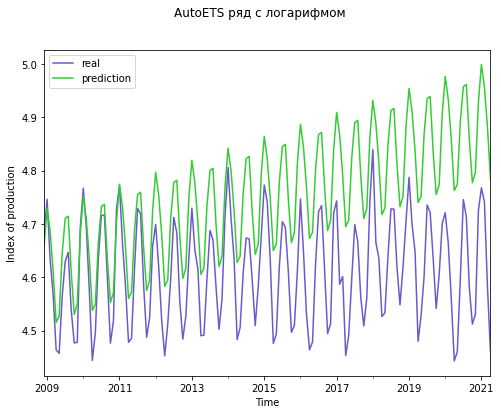

In [73]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
dflog_test.plot(label='real', color='slateblue')
y_pred_autoets_log.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('AutoETS ряд с логарифмом')
plt.show();

## LGT, DLT

Попробуем модели LGT, DLT из ORBIT

https://orbit-ml.readthedocs.io/en/latest/tutorials/dlt.html

https://orbit-ml.readthedocs.io/en/latest/tutorials/lgt.html

In [74]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull

Для них нужно немного подготовить данные

In [75]:
train = pd.DataFrame(list(df_train.reset_index().uti), list(df_time[:len(df_train)]), columns=['uti'])
train = train.reset_index() 
test = pd.DataFrame(list(df_test.reset_index().uti), list(df_time[len(df_train):]), columns=['uti'])
test = test.reset_index()

In [76]:
trainlog = pd.DataFrame(list(dflog_train.reset_index().log_uti), list(df_time[:len(df_train)]), columns=['uti'])
trainlog = trainlog.reset_index() 
testlog = pd.DataFrame(list(dflog_test.reset_index().log_uti), list(df_time[len(df_train):]), columns=['uti'])
testlog = testlog.reset_index()

### LGT

#### Обычные индексы

In [77]:
lgt = LGTFull(
    response_col='uti',
    date_col='index',
    seasonality=12
)

In [78]:
lgt.fit(df=train)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2af9ff5e07f97061bbe4badb0f8a2e36 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [79]:
predicted_df_lgt = lgt.predict(df=test)

In [80]:
lgt_prediction = predicted_df_lgt['prediction']
lgt_prediction.index = predicted_df_lgt['index']

In [81]:
MAE_ind.append(mae(lgt_prediction, df_test))

In [82]:
print(f'MAE LGT ряд без логарифма: {mae(lgt_prediction, df_test)}') 

MAE LGT ряд без логарифма: 9.004888951587589


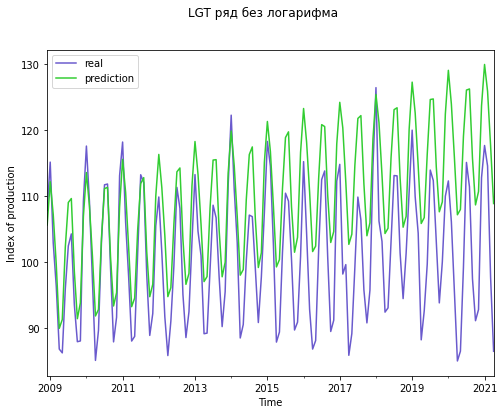

In [83]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
df_test.plot(label='real', color='slateblue')
lgt_prediction.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('LGT ряд без логарифма')
plt.show();

#### Логарифмированные

In [84]:
lgt_log = LGTFull(
    response_col='uti',
    date_col='index',
    seasonality=12
)

In [85]:
lgt_log.fit(df=trainlog)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [86]:
predicted_df_lgt_log = lgt_log.predict(df=testlog)

In [87]:
lgt_prediction_log = predicted_df_lgt_log['prediction']
lgt_prediction_log.index = predicted_df_lgt_log['index']

In [88]:
MAE_log.append(mae(np.exp(lgt_prediction_log), df_test))

In [89]:
print(f'MAE LGT ряд с логарифмом: {mae(np.exp(lgt_prediction_log), df_test)}') 

MAE LGT ряд с логарифмом: 41.44486046996002


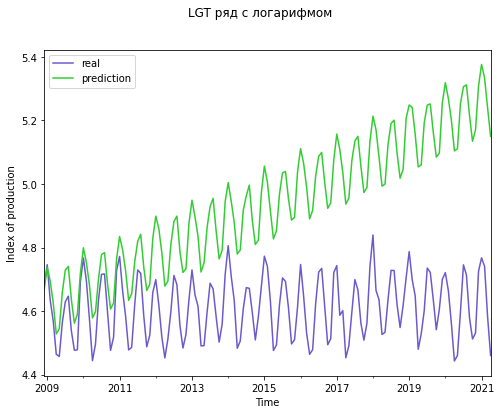

In [90]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
dflog_test.plot(label='real', color='slateblue')
lgt_prediction_log.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('LGT ряд с логарифмом')
plt.show();

### DLT

#### Обычные индексы

In [91]:
dlt = DLTFull(
    response_col='uti',
    date_col='index',
    seasonality=12
)

In [92]:
dlt.fit(df=train)
predicted_df_dlt = dlt.predict(df=test)
dlt_prediction = predicted_df_dlt['prediction']
dlt_prediction.index = predicted_df_dlt['index']

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0a449c7523386cce384e92a998e71c8 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [93]:
MAE_ind.append(mae(dlt_prediction, df_test))

In [94]:
print(f'MAE DLT ряд без логарифма: {mae(dlt_prediction, df_test)}') 

MAE DLT ряд без логарифма: 5.702480983079002


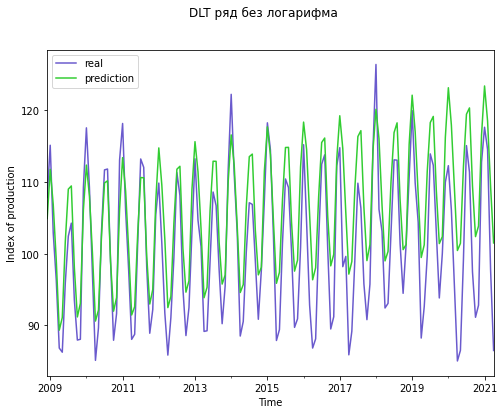

In [95]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
df_test.plot(label='real', color='slateblue')
dlt_prediction.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('DLT ряд без логарифма')
plt.show();

#### Логарифмированные

In [96]:
dlt_log = DLTFull(
    response_col='uti',
    date_col='index',
    seasonality=12
)

In [97]:
dlt_log.fit(df=trainlog)
predicted_df_dlt_log = dlt_log.predict(df=testlog)
dlt_prediction_log = predicted_df_dlt_log['prediction']
dlt_prediction_log.index = predicted_df_dlt_log['index']

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [98]:
MAE_log.append(mae(np.exp(dlt_prediction_log), df_test))

In [99]:
print(f'MAE DLT ряд с логарифмом: {mae(np.exp(dlt_prediction_log), df_test)}') 

MAE DLT ряд с логарифмом: 38.260133667608606


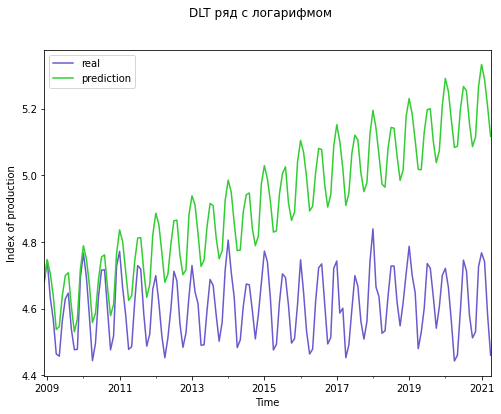

In [100]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))
dflog_test.plot(label='real', color='slateblue')
dlt_prediction_log.plot(label='prediction', color='limegreen')
axs.set_xlabel('Time')
axs.set_ylabel('Index of production')
axs.legend()
fig.suptitle('DLT ряд с логарифмом')
plt.show();

##Prophet

In [101]:
from prophet import Prophet

In [102]:
train_p = pd.DataFrame(list(df_train.reset_index().uti), list(df_time[:len(df_train)]), columns=['y'])
train_p = train_p.reset_index()
train_p = train_p.rename(columns={"index":"ds"})

test_p = pd.DataFrame(list(df_test.reset_index().uti), list(df_time[len(df_train):]), columns=['y'])
test_p = test_p.reset_index()
test_p = test_p.rename(columns={"index":"ds"})

In [103]:
train_p_log = pd.DataFrame(list(dflog_train.reset_index().log_uti), list(df_time[:len(df_train)]), columns=['y'])
train_p_log = train_p_log.reset_index()
train_p_log = train_p_log.rename(columns={"index":"ds"})

test_p_log = pd.DataFrame(list(dflog_test.reset_index().log_uti), list(df_time[len(df_train):]), columns=['y'])
test_p_log = test_p_log.reset_index()
test_p_log = test_p_log.rename(columns={"index":"ds"})

### Обычные индексы

In [104]:
m = Prophet()
m.fit(train_p)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [105]:
f = test_p.drop('y', axis=1)
prediction_pro = m.predict(f)
y_pred_pro = prediction_pro[['yhat', 'yhat_lower', 'yhat_upper']]
y_pred_pro.index = df_test.index

In [106]:
MAE_ind.append(mae(prediction_pro[['yhat']], df_test))

In [107]:
print(f'MAE Prophet ряд без логарифма: {mae(prediction_pro[["yhat"]], df_test)}') 

MAE Prophet ряд без логарифма: 12.925234890008474


### Логарифмированные

In [108]:
m_log = Prophet()
m_log.fit(train_p_log)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [109]:
f_log = test_p_log.drop('y', axis=1)
prediction_pro_log = m_log.predict(f_log)
y_pred_pro_log = prediction_pro_log[['yhat', 'yhat_lower', 'yhat_upper']]
y_pred_pro_log.index = dflog_test.index

In [110]:
MAE_log.append(mae(np.exp(prediction_pro_log[['yhat']]), df_test))

In [111]:
print(f'MAE Prophet ряд с логарифмом: {mae(np.exp(prediction_pro_log[["yhat"]]), df_test)}') 

MAE Prophet ряд с логарифмом: 14.87491805504934


## Таблица с метриками всех моделей

In [112]:
models = ['Naive', 'Naive season', 'SARIMA', 'Auto SARIMA', 'ETS(AAA)', 'AutoETS', 'LGT', 'DLT', 'Prophet']
table = pd.DataFrame(columns = ['Model', 'MAE using initial index', 'MAE using log index'])
table.Model=models
table['MAE using initial index'] = MAE_ind
table['MAE using log index'] = MAE_log

In [113]:
table

,Model,MAE using initial index,MAE using log index
0,Naive,10.499721,10.499721
1,Naive season,3.138785,3.138785
2,SARIMA,8.393494,16.895219
3,Auto SARIMA,7.319396,4.784371
4,ETS(AAA),8.089912,11.084598
5,AutoETS,8.343410,15.661311
6,LGT,9.004889,41.444860
7,DLT,5.702481,38.260134
8,Prophet,12.925235,14.874918


Лучшая модель оказалась **наивная с учетом сезонности**.

Такое можно было ожидать, так как последнее время не было роста производства в рассматриваемой отрасли, а засчет сильной сезонности и малых изменений в отрасли за последние 12 лет такая модель проявила себя лучше всего.

# Задание 5 «Кто на свете всех милее?»

In [114]:
df_test.index[-1] #последнее наблюдение

Period('2021-04', 'M')

In [115]:
df_test.index[-13:-1]+13 #следующий год

PeriodIndex(['2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10',
             '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04'],
            dtype='period[M]', name='Time', freq='M')

In [116]:
fh_new = ForecastingHorizon(df_test.index[-13:-1]+13 , is_relative=False)

In [117]:
forecaster = NaiveForecaster(strategy="last", sp=12) #лучшая модель
forecaster.fit(df.uti)
y_pred = forecaster.predict(fh_new)

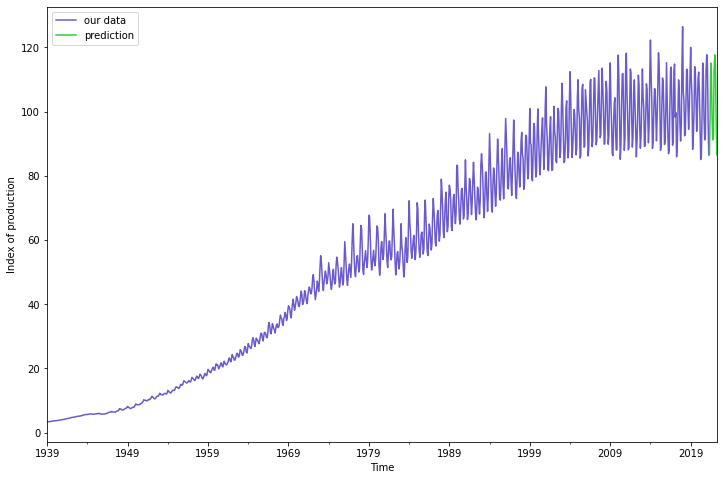

In [118]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))
df.uti.plot(ax=ax, label='our data', color='slateblue')
y_pred.plot(ax=ax, label='prediction', color='limegreen')
plt.xlabel('Time')
plt.ylabel('Index of production')
plt.legend()
plt.show();

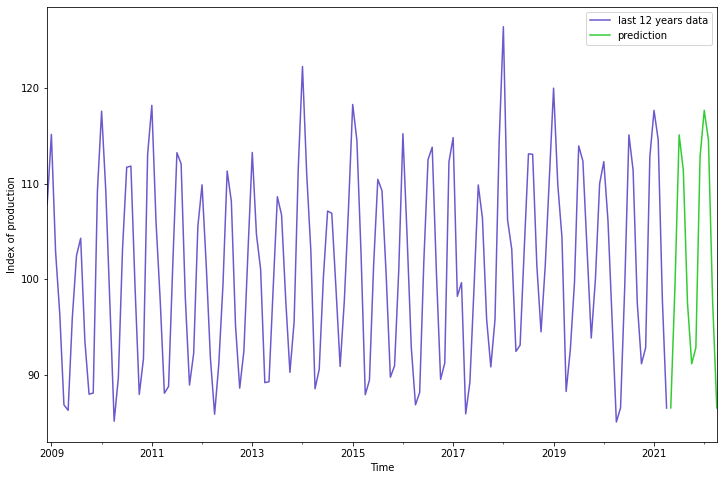

In [119]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))
df_test.plot(ax=ax, label='last 12 years data', color='slateblue')
y_pred.plot(ax=ax, label='prediction', color='limegreen')
plt.xlabel('Time')
plt.ylabel('Index of production')
plt.legend()
plt.show();

# Задание 6 «Хождение в народ»

Мы взяли данные по индивидам за 2011-2019 года по репрезентативным выборкам.

Нас интересовали переменные удовлетворенностью жизни, образования и дохода. Для этого в нашем датасете будут такие переменные:

* satis - удовлетворенность жизнью

  Ответ на вопрос:

  Насколько Вы удовлетворены своей жизнью в целом в настоящее время?

* satis_cat - перевели категории в числа

    'Полностью удовлетворены': 5.0,

    'Скорее удовлетворены': 4.0,

    'И да, и нет': 3.0,

    'Совсем не удовлетворены': 2.0,

    'Не очень удовлетворены':1.0

* income - доход

  Ответ на вопрос:
  
  Сколько всего денег в течение последних 30 дней Вы лично получили, считая все: зарплату,
  пенсии, премии, прибыли, пособия, материальную помощь, случайные заработки и другие
  денежные поступления?

* educ - образование

* year - год опроса

Сразу с приватного источника не получилось скачать, поэтому после обработки и соединения таблиц у себя на софте сразу загрузили csv для удобства дальнейшей работы.

In [120]:
!wget -O rlms.csv https://www.dropbox.com/s/6btgvqrk5ut8oa0/rlms.csv?dl=0

--2021-06-16 12:56:54--  https://www.dropbox.com/s/6btgvqrk5ut8oa0/rlms.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/6btgvqrk5ut8oa0/rlms.csv [following]
--2021-06-16 12:56:55--  https://www.dropbox.com/s/raw/6btgvqrk5ut8oa0/rlms.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccab43106e503bb14fdf247f7f8.dl.dropboxusercontent.com/cd/0/inline/BQjWBoITu4qYLNFSryJfP0Y8eXws12o7JeVlu9mzDXB1fG2Lhw8onMM7tbp5fCHLnEZK81UDDQrWY_5hJZIAyo5Eh9RyznV3_bwWu6RC1ac-3zX4aVGTsufVZmqHrcozmJhsROrC-k_JCxFbsmJKHHAM/file# [following]
--2021-06-16 12:56:55--  https://uccab43106e503bb14fdf247f7f8.dl.dropboxusercontent.com/cd/0/inline/BQjWBoITu4qYLNFSryJfP0Y8eXws12o7JeVlu9mzDXB1fG2Lhw8onMM7tbp5fCHLnEZK81UDDQrWY_5hJZIAyo5Eh9RyznV3_

In [121]:
data = pd.read_csv('rlms.csv')

In [122]:
data = data.drop('Unnamed: 0', axis=1)

In [123]:
data.head()

,satis,educ,income,year,idind,satis_cat,educ_cat
0,"И да, и нет",7-9 классов школы (незак. средн) + ПТУ без дип...,16374,2019,7,3,10
1,Скорее удовлетворены,техникум с дипломом,16000,2019,9,4,18
2,Не очень удовлетворены,8 классов школы,14700,2019,36,1,8
3,Совсем не удовлетворены,10 и более классов школы и какое-либо професс....,18000,2019,60,2,16
4,"И да, и нет",10 и более классов школы и какое-либо професс....,26700,2019,92,3,16


In [124]:
data.shape

(37362, 7)

In [125]:
data.describe()

,income,year,idind,satis_cat,educ_cat
count,3.736200e+04,37362.000000,37362.000000,37362.000000,37362.000000
mean,2.004401e+04,2015.020154,23204.909239,3.118837,16.461030
std,2.953520e+04,2.573571,13248.996742,1.241705,4.029832
min,3.900000e+01,2011.000000,7.000000,1.000000,5.000000
25%,1.001775e+04,2013.000000,10862.000000,2.000000,14.000000
50%,1.520000e+04,2015.000000,25780.500000,4.000000,18.000000
75%,2.425525e+04,2017.000000,34875.000000,4.000000,20.000000
max,2.774000e+06,2019.000000,52950.000000,5.000000,23.000000


# Задание 7 «Кому на Руси жить хорошо?»

Наши вопросы: 

1. **"Ведет ли более высокий ежемесячный доход к большей удовлетворенности жизнью?"**

Много работ посвящено изучению этого вопроса, в различных статьях на похожих данных субъективного состояния удовлетворенности находили этот эффект (данных опросов в Германии, Британии).

* [Income and well-being: an empirical analysis of the comparison income effect](https://www.sciencedirect.com/science/article/pii/S004727270400088X?casa_token=QeFyd9zlWtAAAAAA:5lUF-x38TDV5WwzOvPVzHPdp1WZDj8EjTL8AevlILrgTNr8JgqEO3UiWThdvbyxHE3mGjR81zJ0c)

* [Income and happiness: Evidence, explanations and
economic implications](https://halshs.archives-ouvertes.fr/halshs-00590436/file/wp200624.pdf)

Более того, по данным RLMS 1994-2000 года исследовалась эта связь и детерминанты удовлетворенности жизни и была найдена сильная положительная корреляция ([When Information Dominates Comparison:
A Panel Data Analysis Using Russian Subjective Data](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/39880/wp495.pdf?sequence=2)). В нашей работе мы попытаемся подтвердить этот эффект на новых данных.

2. **"Ведет ли более высокое школьное образование к большей удовлетворенности жизнью?"**

Этот вопрос также рассматривался во многих работах и даных по индивидам в различных странах, находя положительную связь.

* [Does Education Affect Happiness? Evidence for Spain](https://link.springer.com/article/10.1007%252Fs11205-011-9874-x)

* [How Education Enhances Happiness: Comparison
of Mediating Factors in Four East Asian Countries](https://link.springer.com/content/pdf/10.1007/s11205-011-9798-5.pdf)

* [Education and happiness: an alternative hypothesis](https://www.tandfonline.com/doi/full/10.1080/13504851.2015.1111982?casa_token=XnbGzrLS6PEAAAAA%3ADdHRcUS2-FouSSiHMQA19jFfToKw2RDIchLA6PgT5SodiNt6TL4b7UP7u-P5nCS-OV0Hwo7liAyfMfk)

В нашей работе мы попробуем проверить наличие этой связи и для России.


# Задание 8 «Сделай красиво!»

Нарисуем скэттер плоты, барплоты и боксплоты по переменным образования и дохода в зависимости от удовлетворенности. 

Скэттер плоты не очень показательные при работе с категориальной переменной удовлетворенности жизни, поэтому на них можно сильно не фокусироваться. Барплоты показывают как распределены средние значения дохода и образования в завимости от категории удовлетворенности. Боксплоты показывают распределения показателей по группам удовлетворенности.

Замечания: 
в барплоте дохода не будем показывать выбросы, поскольку несколько экстремальных значений смещают график и делают его непоказательным. не будем также изображать скэттер плот с уровнем образования, так как он неинформативен.

## Для первого вопроса (связь дохода и удовлетворенности жизнью)

In [126]:
import seaborn as sns

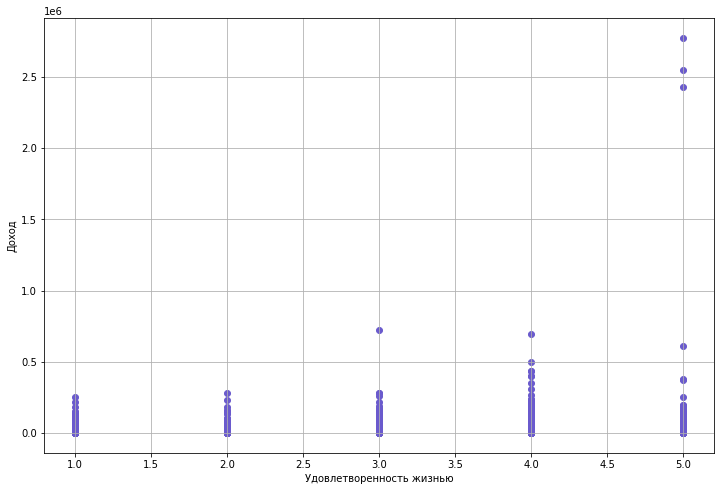

In [127]:
plt.figure(figsize=(12, 8))
plt.scatter(data.satis_cat, data.income, color='slateblue')
plt.grid()
plt.xlabel('Удовлетворенность жизнью')
plt.ylabel('Доход')
plt.show()

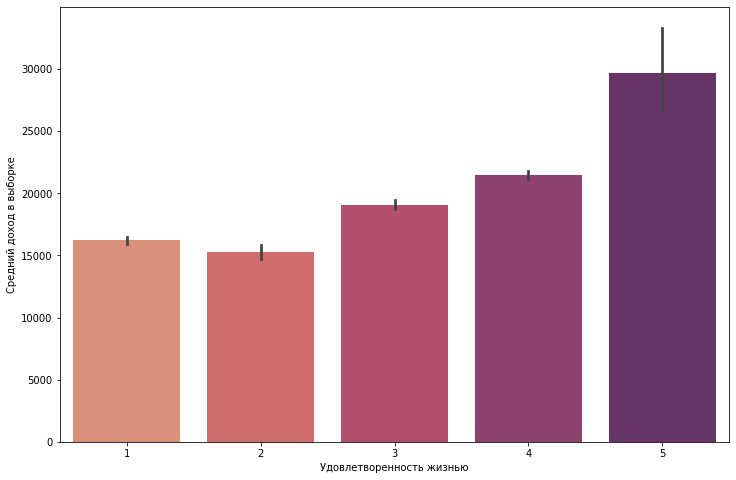

In [128]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x='satis_cat', y='income', data=data, palette="flare")
ax.set(xlabel='Удовлетворенность жизнью', ylabel='Средний доход в выборке');

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



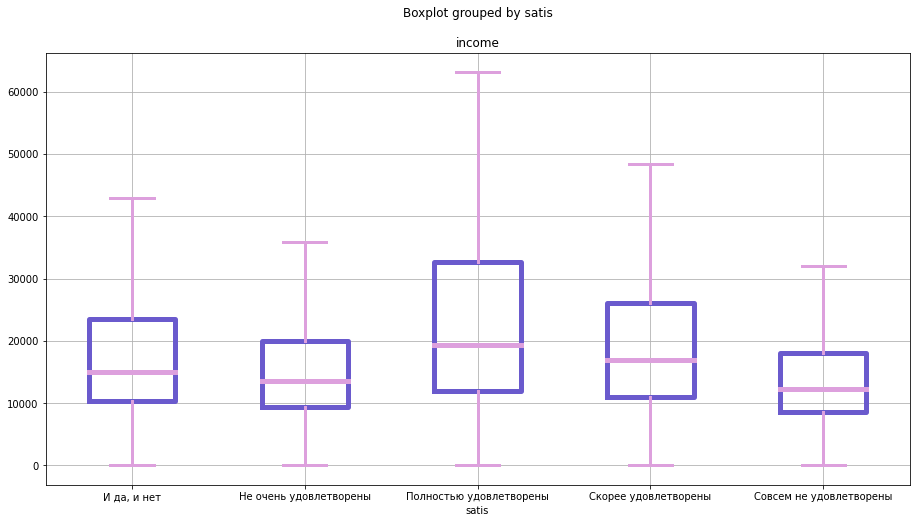

In [130]:
data.boxplot('income',  grid=True, by='satis', color='plum', figsize=(15, 8), showfliers=False,
             medianprops={'linewidth': 5, 'color': 'plum'}, 
             boxprops={'color':'slateblue', 'linewidth': 5},
             whiskerprops={'color':'plum', 'linewidth': 3},
             capprops={'color':'plum', 'linewidth': 3});


## Для второго вопроса (связь образования и удовлетворенности жизнью)

Скэттер плот мы не рисовали, так как он для уровня образования и уровня удовлевторенности жизнью не очень показательный

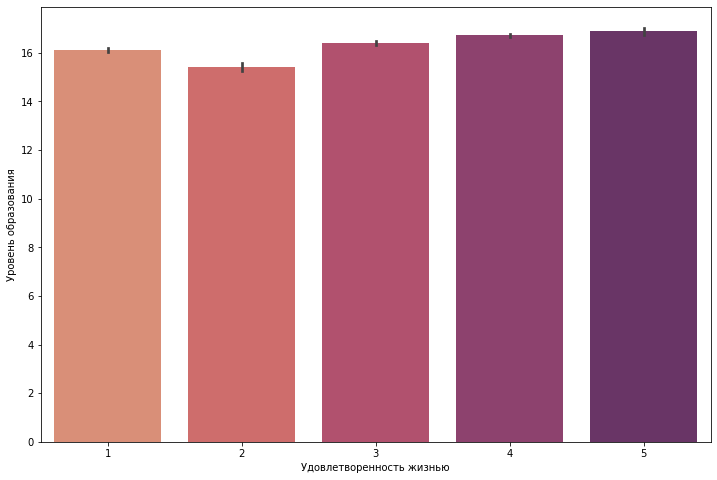

In [142]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x='satis_cat', y='educ_cat', data=data, palette="flare")
ax.set(xlabel='Удовлетворенность жизнью', ylabel='Уровень образования');

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



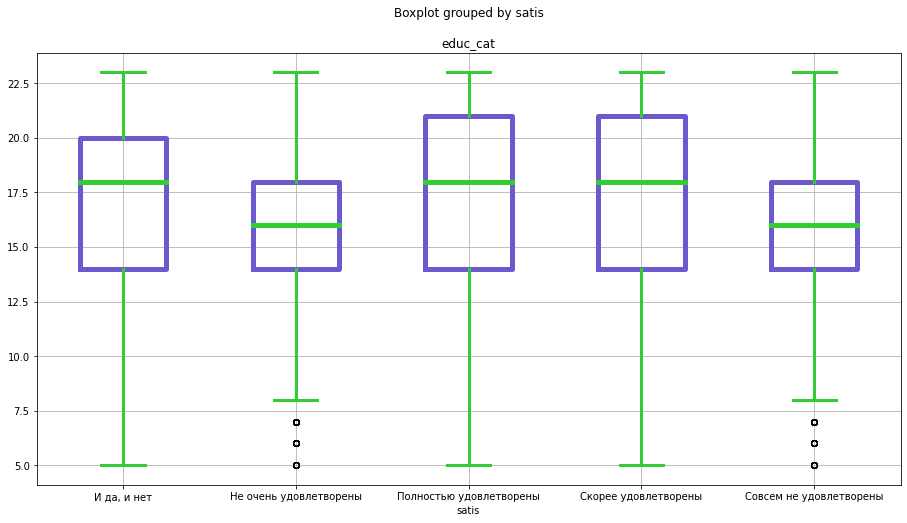

In [129]:
data.boxplot('educ_cat',  grid=True, by='satis', figsize=(15, 8),
             medianprops={'linewidth': 5, 'color': 'limegreen'}, 
             boxprops={'color':'slateblue', 'linewidth': 5},
             whiskerprops={'color':'limegreen', 'linewidth': 3},
             capprops={'color':'limegreen', 'linewidth': 3});


Заметим, что четкой зависимости между уровнем дохода или образованием и удовлетворенностью жизнью не прослеживается. Хотя можно сказать, что статусу полностью удовлетворенных в среднем соответствуют более высокие значения дохода и уровня образования, а неудовлетворенные, как правило, имеют менее высокие.

In [131]:
data.groupby('satis_cat').mean()['income']

satis_cat
1    16213.316369
2    15271.806013
3    19096.368569
4    21445.117157
5    29687.053298
Name: income, dtype: float64

In [143]:
data.groupby('satis_cat').mean()['educ_cat']

satis_cat
1    16.125309
2    15.421334
3    16.403430
4    16.731719
5    16.879985
Name: educ_cat, dtype: float64

# Задание 9 «Три сестры»

In [132]:
!pip install linearmodels

     |████████████████████████████████| 1.5MB 5.2MB/s 


In [133]:
from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels.panel.results import PanelEffectsResults
from linearmodels.panel.results import RandomEffectsResults
from linearmodels.panel import RandomEffects
import statsmodels.api as sm

In [134]:
data_index = data[['idind','year']]
data_index = pd.MultiIndex.from_frame(data_index)
d = data.set_index(data_index)

## Pooled

In [135]:
exog_vars = ["educ_cat", "income"]
exog = sm.add_constant(d[exog_vars])
mod_pooled = PooledOLS(d['satis_cat'], exog)
pooled_res = mod_pooled.fit(cov_type='clustered', cluster_entity=True)
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:              satis_cat   R-squared:                        0.0143
Estimator:                  PooledOLS   R-squared (Between):              0.0348
No. Observations:               37362   R-squared (Within):              -0.0043
Date:                Wed, Jun 16 2021   R-squared (Overall):              0.0143
Time:                        12:57:03   Log-likelihood                -6.083e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      270.07
Entities:                        4483   P-value                           0.0000
Avg Obs:                       8.3342   Distribution:                 F(2,37359)
Min Obs:                       1.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             34.114
                            

## Time Fixed Effects

In [136]:
exog_vars = ["educ_cat", "income"]
mod_te = PanelOLS(d['satis_cat'], d[exog_vars], time_effects=True)
te_res = mod_te.fit(cov_type='clustered', cluster_entity=True)
print(te_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              satis_cat   R-squared:                        0.0144
Estimator:                   PanelOLS   R-squared (Between):              0.2236
No. Observations:               37362   R-squared (Within):              -0.0046
Date:                Wed, Jun 16 2021   R-squared (Overall):              0.2080
Time:                        12:57:04   Log-likelihood                -6.081e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      273.57
Entities:                        4483   P-value                           0.0000
Avg Obs:                       8.3342   Distribution:                 F(2,37351)
Min Obs:                       1.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             34.107
                            

## Random Fixed effects

In [137]:
exog_vars = ["educ_cat", "income"]
mod_re = RandomEffects(d['satis_cat'], d[exog_vars])
re_res = mod_re.fit(cov_type='clustered', cluster_entity=True)
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:              satis_cat   R-squared:                        0.4926
Estimator:              RandomEffects   R-squared (Between):              0.8949
No. Observations:               37362   R-squared (Within):              -0.0509
Date:                Wed, Jun 16 2021   R-squared (Overall):              0.8262
Time:                        12:57:04   Log-likelihood                -5.279e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.814e+04
Entities:                        4483   P-value                           0.0000
Avg Obs:                       8.3342   Distribution:                 F(2,37360)
Min Obs:                       1.0000                                           
Max Obs:                      10.0000   F-statistic (robust):          2.317e+04
                            

Проведем тест Хаусмана:

https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8

In [138]:
import numpy.linalg as la
from scipy import stats
import numpy as np

def hausman(fe, re):
  b = fe.params
  B = re.params
  v_b = fe.cov
  v_B = re.cov
  da = b[np.abs(b) < 1e8].size
  chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
  
  pval = stats.chi2.sf(chi2, da)
  return chi2, da, pval


hausman_results = hausman(te_res, re_res) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 2604.4567296462556
degrees of freedom: 2
p-Value: 0.0


Отсюда следует, что нулевая гипотеза отвергается и более предпочтительна модель с **фиксированными эффектами**

А в сравнении с Pooled в табличке с результатами F-статистика в тесте Вальда равна  4.8973 и нулевая гипотеза отвергается, то есть более предпочтительна модель с фиксированными годовыми эффектами

# Задание 10 «Ответ на главный вопрос»

В каждой из примененных моделях коэффициенты перед каждым выбранным регрессором положительны и значимы, а значит наши предположения верные:

1. Более высокие доходы ведут к большей удовлетворенности жизнью

2. Более высокое образование ведет к большей удовлетворенности жизнью


Тем не менее, в этих регрессиях было мало предикторов, поэтому точно утверждать эти выводы нельзя - могут быть третьи факторы, влияющие на зависимую и независимую переменную.

Поэтому ответ на главный вопрос так и остается:

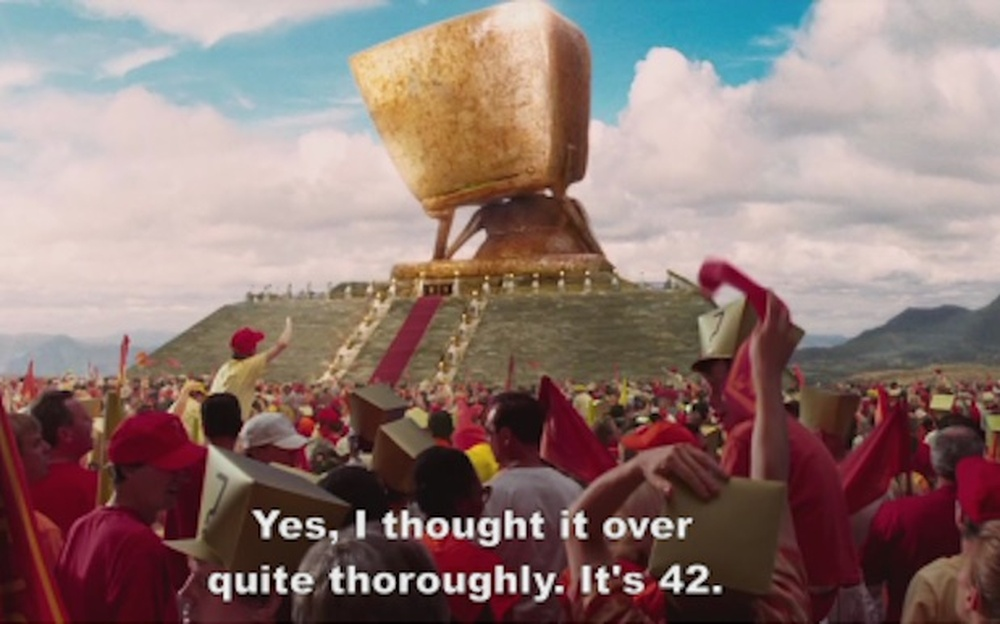